# Lab:  Nonlinear Least Squares for Modeling Materials

Nonlinear least squares (NLLS) is a widely-used method for modeling data.  In NLLS, we wish to fit a model of the form,

     yhat = g(x,w)
     
where `w` is a vector of paramters and `x` is the vector of predictors.  We find `w` by minimizing a least-squares function 

     f(w) = \sum_i (y_i - g(x_i,w))^2
     
where the summation is over training samples `(x_i,y_i)`.  This is similar to linear least-squares, but the function `g(x,w)` may not be linear in `w`.  In general, this optimization has no closed-form expression.  So numerical optimization must be used.  

In this lab, we will implement gradient descent on NLLS in a problem of physical modeling of materials.  Specifically, we will estimate parameters for expansion of copper as a function of temperature using a real dataset.  In doing this lab, you will learn to:
* Set up a nonlinear least squares as an unconstrained optimization function
* Compute initial parameter estimates for a simple rational model
* Compute the gradients of the least squares objective
* Implement gradient descent for minimizing the objective
* Implement momentum gradient descent
* Visualize the convergence of the algorithm

We first import some key packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LinearRegression

## Load the Data

The NIST agency has an excellent [nonlinear regression website](https://www.itl.nist.gov/div898/strd/nls/nls_main.shtml) that has several datasets for nonlinear regression problems.  In this lab, we will use the data from a NIST study involving the thermal expansion of copper. The response variable is the coefficient of thermal expansion, and the predictor variable is temperature in degrees kelvin.  

> Hahn, T., NIST (1979), Copper Thermal Expansion Study.  (unpublished}

You can download the data as follows.

In [2]:
url = 'https://itl.nist.gov/div898/strd/nls/data/LINKS/DATA/Hahn1.dat'
df = pd.read_csv(url, skiprows=60, sep=' ',skipinitialspace=True, names=['x0','y0','dummy'])
df.head()

,x0,y0,dummy
0,0.591,24.41,NaN
1,1.547,34.82,NaN
2,2.902,44.09,NaN
3,2.894,45.07,NaN
4,4.703,54.98,NaN


Extract the `x0` and `y0` into arrays.  Rescale, `x0` and `y0` to values between `0` and `1` by dividing `x0` and `y0` by the maximum value.  Store the scaled values in vectors `x` and `y`.  The rescaling will help with the conditioning of the fitting.  Plot, `y` vs. `x`. 

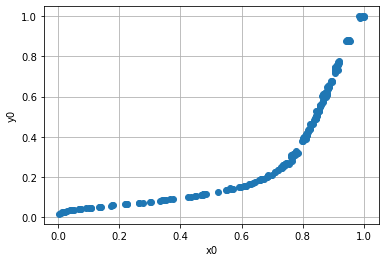

In [11]:
# TODO
x0 = np.array(df['x0'])
y0 = np.array(df['y0'])

x = x0/np.max(x0)
y = y0/np.max(y0)

#plt.plot(x, y)
plt.plot(x, y, 'o')
plt.xlabel('x0')
plt.ylabel('y0')
plt.grid()
plt.show()

To make the problem a little more challenging, we will add some noise.  Add random Gaussian noise with mean 0 and std. dev = 0.05 to `y`.  Store the noisy results in `yn`. You can use the `np.random.normal()` function to add Gaussian noise. Plot `yn` vs. `x`.

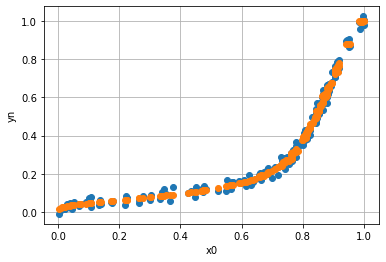

In [113]:
# TODO
yn = y + np.random.normal(0, 0.02, len(y0))
#yn

plt.plot(x, yn, 'o')
plt.plot(x, y, 'o')
plt.xlabel('x0')
plt.ylabel('yn')
plt.grid()
plt.show()

Split the data `(x,yn)` into training and test.  Let `xtr,ytr` be training data and `xts,yts` be the test data.  You can use the `train_test_split` function.  Set `test_size=0.33` so that 1/3 of the samples are held out for test.

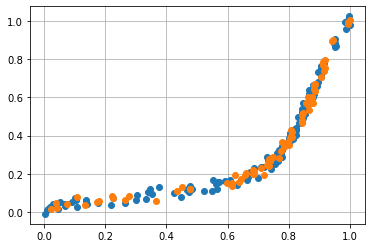

In [114]:
from sklearn.model_selection import train_test_split

# TODO
Xtr, Xts, ytr, yts = train_test_split(x, yn, test_size = 0.33)

plt.plot(Xtr, ytr, 'o')
plt.plot(Xts, yts, 'o')
plt.grid()
plt.show()

## Initial Fit for a Rational Model

The [NIST website](https://www.itl.nist.gov/div898/strd/nls/data/hahn1.shtml) suggests using a *rational* model of the form,

      yhat = (a[0] + a[1]*x + ... + a[d]*x^d)/(1 + b[0]*x + ... + b[d-1]*x^d)
      
with `d=3`.  The model parameters are `w = [a[0],...,a[d],b[0],...,b[d-1]]` so there are `2d+1` parameters total.    Complete the function below that takes vectors `w` and `x` and predicts a set of values `yhat` using the above model.
   

In [115]:
def predict(w,x):
    
    # Get the length
    d = (len(w)-1)//2
    
    # TODO.  Extract a and b from w
    a = w[ : (d+1) ]
    b = w[ d+1 : ]
    
    # TODO.  Compute yhat.  You may use the np.polyval function
    # But, remember you must flip the order the a and b
    arev = a[::-1]
    brev = b[::-1]
    znum = np.polyval(arev, x)
    zden = 1+ x * np.polyval(brev, x)
    yhat = znum/zden
    return yhat

When we fit with a nonlinear model, most methods only get convergence to a local minima.  So, you need a good initial condition.  For a rational model, one way to get is to realize that if:


    y ~= (a[0] + a[1]*x + ... + a[d]*x^d)/(1 + b[0]*x + ... + b[d-1]*x^d)
    
Then:

    y ~= a[0] + a[1]*x + ... + a[d]*x^d - b[0]*x*y + ... - b[d-1]*x^d*y.
    
So, we can solve for the the parameters `w = [a,b]` from linear regression of the predictors,

    Z[i,:] = [ x[i], ... , x[i]**d, y[i]*x[i], ... , y[i}*x[i]**d ] 

In [116]:
d = 3

# TODO.  Create the transformed feature matrix
powd = np.arange(1, d+1)
Znum = Xtr[:, None] ** powd[None, :]
Zden = -ytr[:, None] * Znum
Z = np.hstack((Znum, Zden))

# TODO.  Fit with parameters with linear regression
regr = LinearRegression()
regr.fit(Z, ytr)

# TODO
# Extract the parameters from regr.coef_ and regr.intercept_ and store the parameter vector in winit

w0 = regr.coef_
a0 = regr.intercept_
winit = np.hstack((a0, w0))

winit

array([ 0.01923806,  0.08876407, -0.49765923,  0.4372529 , -4.52387739,
        6.0858412 , -2.51834299])

Now plot the predicted values of the `yhat` vs. `x` using your estimated parameter `winit` for 1000 values `x` in `[0,1]`.  On the same plot, plot `yts` vs. `xts`.  You will see that you get a horrible fit.

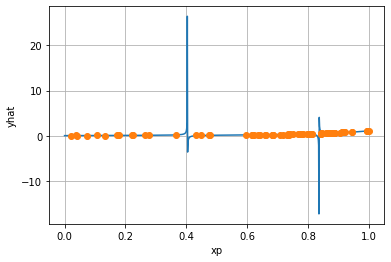

In [117]:
# TODO
xp = np.linspace(0 ,1, 1000)
yhat = predict(winit, xp)
plt.plot(xp, yhat)
plt.plot(Xts, yts, 'o')
plt.xlabel('xp')
plt.ylabel('yhat')
plt.grid()
plt.show()

The reason the previous fit is poor is that the denominator in `yhat` goes close to zero.   To avoid this problem, we can use Ridge regression, to try to keep the parameters close to zero.  Re-run the fit above with `Ridge` with `alpha = 1e-3`. You should see you get a reasonable, but not perfect fit.

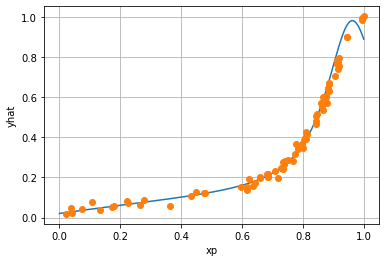

In [118]:
# TODO.  Fit with parameters with linear regression
alpha=1e-3
regr = Ridge(alpha=alpha)
regr.fit(Z, ytr)

# TODO
# Extract the parameters from regr.coef_ and regr.intercept_
w0 = regr.coef_
a0 = regr.intercept_
winit = np.hstack((a0, w0))

# TODO
xp = np.linspace(0 ,1, 1000)
yhat = predict(winit, xp)
plt.plot(xp, yhat)
plt.plot(Xts, yts, 'o')
plt.xlabel('xp')
plt.ylabel('yhat')
plt.grid()
plt.show()

## Creating a Loss Function

We can now use gradient descent to improve our initial estimate.  Complete the following function to compute

    f(w) = 0.5*\sum_i (y[i] - yhat[i])^2
    
and `fgrad`, the gradient of `f(w)`.

In [119]:
def feval(w,x,y):
        
    
    # TODO.  Parse w
    d = (len(w) - 1) // 2
    a = w[0 : d+1]
    b = w[d+1 : ]
    
    # TODO.  Znum[i,j] = x[i]**j
    Znum = np.zeros((len(x), d+1))
    for j in range(d + 1):
      Znum[ : , j] = x[:] ** j

    # TODO.  Zden[i,j] = x[i]**(j+1)
    Zden = np.zeros((len(x), d))
    for j in range(d):
      Zden[ : , j] = x[:] ** (j + 1)

    # TODO.  Compute yhat 
    yhat = np.zeros((len(x)))
    for i in range(len(x)):
      yhat[i] = Znum[i, :].dot(a)/(1+Zden[i, :].dot(b))

    # Compute the numerator and denominator
    
    # TODO.  Compute loss
    f = 0.5 * np.sum(np.square(y - yhat))
    
    # TODO.  Compute gradients
    grada = np.zeros(len(a))
    gradb = np.zeros(len(b))
    for j in range(len(a)):
      grada[j] = -np.sum((y - yhat) * Znum[:, j]/(1+np.matmul(Zden, b)))
    for j in range(len(b)):
      gradb[j] = np.sum((y - yhat) * yhat * Zden[:, j]/(1+np.matmul(Zden, b)))

    fgrad = np.concatenate((grada, gradb))
    
    return f, fgrad


Test the gradient function:
* Take `w0=winit` and compute `f0,fgrad0 = feval(w0,xtr,ytr)`
* Take `w1` very close to `w0` and compute `f1,fgrad1 = feval(w1,xtr,ytr)`
* Verify that `f1-f0` is close to the predicted value based on the gradient.

In [120]:
# TODO
w0 = winit 
f0, fgrad0 = feval(w0, Xtr, ytr)
w1 = w0 + 1e-6
f1, fgrad1 = feval(w1, Xtr, ytr)
print(f1- f0)
print((fgrad0.dot(w1-w0)))

2.644124577833029e-05
2.6308260017200922e-05


## Implement gradient descent

We will now try to minimize the loss function with gradient descent.  Using the function `feval` defined above, implement gradient descent.  Run gradient descent with a step size of `alpha=1e-6` starting at `w=winit`.  Run it for `nit=10000` iterations.  Compute `fgd[it]`= the objective function on iteration `it`.  Plot `fgd[it]` vs. `it`.  

You should see that the training loss decreases, but it still hasn't converged after 10000 iterations.

Text(0, 0.5, 'Training loss')

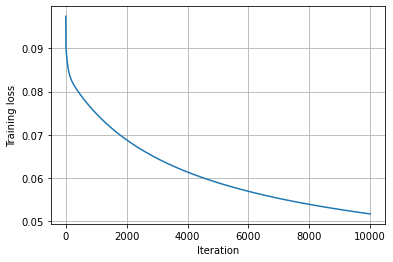

In [121]:
# TODO
# fgd = ...
nit = 10000
step = 1e-6
hist = {'w' :[], 'f' : []}
w0 = winit 

for it in range(nit):
  f0, fgrad0 = feval(w0, Xtr, ytr)
  w0 = w0 - fgrad0*step
  hist['f'].append(f0)
  hist['w'].append(w0)
  
for elem in ('f', 'w'):
  hist[elem] = np.array(hist[elem])

t = np.arange(nit) + 1
plt.plot(t, hist['f'])
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Training loss')




Now, try to get a faster convergence with adaptive step-size using the Armijo rule. Implement the gradient descent with adaptive step size.  Let `fadapt[it]` be the loss function on iteration `it`.  Plot `fadapt[it]` and `fgd[it]` vs. `it` on the same graph.  You should see a slight improvement, but not much.

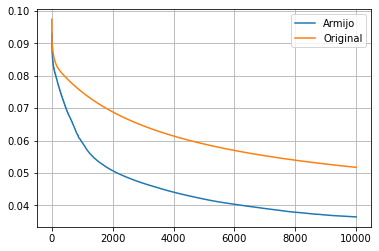

In [122]:
# TODO
# fadapt = ...
nit = 10000
step = 1e-6
hist_Armijo = {'w': [], 'f': []}
w0 = winit
f0, fgrad0 = feval(w0, Xtr, ytr)

for it in range(nit):
  w1 = w0 - step * fgrad0
  f1, fgrad1 = feval(w1, Xtr, ytr)
  df_est = fgrad0.dot(w1 - w0)
  alpha = 0.5
  if (f1-f0 < alpha*df_est) and (f1 < f0):
    step = step*2
    f0 = f1
    fgrad0 = fgrad1
    w0 = w1
  else:
    step = step/2
    #step = np.maximum(step, 1e-6 )
    
  hist_Armijo['f'].append(f0)
  hist_Armijo['w'].append(w0)

    # Convert to numpy arrays
for elem in ('f', 'w'):
  hist_Armijo[elem] = np.array(hist_Armijo[elem])

plt.plot(hist_Armijo['f'])
plt.plot(hist['f'])
plt.legend(('Armijo', 'Original'))
plt.grid()
plt.show()


Using he final estimate for `w` from the adaptive step-size plot the predicted values of the `yhat` vs. `x` usfor 1000 values `x` in `[0,1]`.  On the same plot, plot `yhat` vs. `x` for the initial parameter `w=winit`.  Also, plot `yts` vs. `xts`.  You should see that gradient descent was able to improve the estimat slightly, although the initial estimate was not too bad.

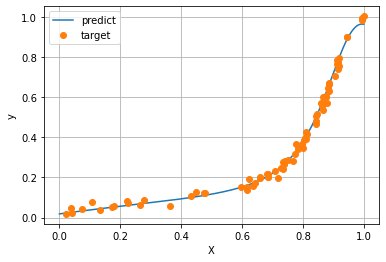

In [123]:
# TODO
xp = np.linspace(0, 1, num = 1000)
w_adpt = hist_Armijo['w'][9999, :]
yhat = predict(w_adpt, xp)

plt.plot(xp, yhat)
plt.plot(Xts, yts, 'o')
plt.xlabel('X')
plt.ylabel('y')
plt.legend(('predict', 'target'))
plt.grid()
plt.show()


## Momentum Gradient Descent

This section is bonus.

One way to improve gradient descent is to use *momentum*.  In momentum gradient descent, the update rule is:

    f, fgrad = feval(w,...)
    z = beta*z + fgrad
    w = w - step*z
    
This is similar to gradient descent, except that there is a second order term on the gradient.  Implement this algorithm with `beta = 0.99` and `step=1e-5`.   Compare the convergence of the loss function with gradient descent.  

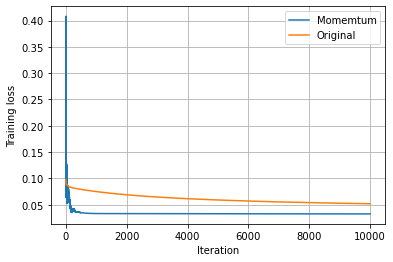

In [129]:
# TODO
nit = 10000
step = 1e-5
beta = 0.99
#shape(winit)
Z = np.zeros(np.shape(winit))
hist_M = {'w': [], 'f': []}
w0 = winit
for it in range(nit):
  f0, fgrad0 = feval(w0, Xtr, ytr)
  Z = beta * Z + fgrad0
  w0 = w0 - step * Z
  hist_M['w'].append(w0)
  hist_M['f'].append(f0)

for elem in ('f', 'w'):
  hist_M[elem] = np.array(hist_M[elem])

t = np.arange(nit) + 1
plt.plot(t, hist_M['f'])
plt.plot(np.arange(10000) + 1, hist['f'])
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Training loss')

plt.legend(('Momemtum', 'Original'))



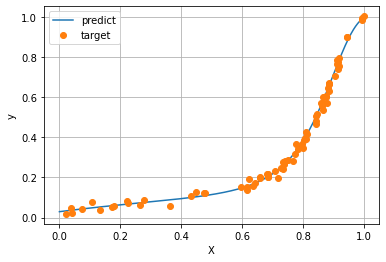

In [130]:
# TODO
# plot yhat vs. x
w = np.array(hist_M['w'])[999, :]
xp = np.linspace(0, 1, num = 1000)
yhat = predict(w, xp)

plt.plot(xp, yhat)
plt.plot(Xts, yts, 'o')
plt.xlabel('X')
plt.ylabel('y')
plt.legend(('predict', 'target'))
plt.grid()
plt.show()



## Beyond This Lab
In this lab, we have just touched at some of the ideas in optimization.  There are several other important algorithms that you can explore:
* [Levenberg-Marquardt](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm) method for non-linear least squares
* Newton's method
* More difficult non-linear least squares problems.